# Introduction to Unsupervised Learning


In [1]:
# Environment Setup and Module Imports
import time
import sys
import os
import importlib

start_time = time.time()

print("Loading 3W Dataset for Autoencoder Novelty Detection")
print("=" * 60)

# Add src to path and import modules
sys.path.append("src")

print("Importing modules...", end=" ")
from src.data_persistence import DataPersistence
from src.unsupervised_preprocessing import UnsupervisedDataLoader
from src import config
import pandas as pd
import numpy as np

# Reload modules to ensure latest changes are picked up
import src.unsupervised_preprocessing

importlib.reload(src.unsupervised_preprocessing)
from src.unsupervised_preprocessing import UnsupervisedDataLoader

# Initialize components
persistence = DataPersistence(base_dir=config.PROCESSED_DATA_DIR, verbose=False)
data_loader = UnsupervisedDataLoader(persistence, config)

print(f"Using data format: {config.SAVE_FORMAT}")

# Verify the method exists
if hasattr(data_loader, "load_per_fold_data"):
    print("Per-fold data loading method available")
else:
    print("❌ Per-fold data loading method not found")

Loading 3W Dataset for Autoencoder Novelty Detection
Importing modules... Using data format: pickle
Per-fold data loading method available


In [2]:
# Data Loading Configuration for Per-Fold Evaluation
MAX_NORMAL_SAMPLES = (
    config.MAX_NORMAL_SAMPLES
)  # Limit normal samples per fold for faster processing
MAX_ANOMALY_SAMPLES = config.MAX_ANOMALY_SAMPLES  # Limit anomaly samples per fold
SELECTED_ANOMALY_CLASSES = config.SELECTED_ANOMALY_CLASSES  # Target anomaly classes

print("Per-Fold Evaluation Configuration:")
print(f"   • Max normal samples per fold: {MAX_NORMAL_SAMPLES}")
print(f"   • Max anomaly samples per fold: {MAX_ANOMALY_SAMPLES}")
print(f"   • Selected anomaly classes: {SELECTED_ANOMALY_CLASSES}")

Per-Fold Evaluation Configuration:
   • Max normal samples per fold: 500
   • Max anomaly samples per fold: 200
   • Selected anomaly classes: [3, 4, 8]


In [3]:
# Load Data for Per-Fold Evaluation
try:
    fold_data = data_loader.load_per_fold_data(
        selected_anomaly_classes=SELECTED_ANOMALY_CLASSES,
        max_normal_samples=MAX_NORMAL_SAMPLES,
        max_anomaly_samples=MAX_ANOMALY_SAMPLES,
    )

    data_ready = True
    total_time = time.time() - start_time

    print(f"✅ Per-fold data loaded: {len(fold_data)} folds in {total_time:.2f}s")

    # Concise summary per fold
    for fold_name, data in fold_data.items():
        train_size = len(data["train_normal"])
        test_normal_size = len(data["test_normal"])
        test_anomaly_size = len(data["test_anomaly"])
        print(
            f"{fold_name}: {train_size} train, {test_normal_size} test normal, {test_anomaly_size} test anomaly"
        )

except Exception as e:
    print(f"❌ Error: {str(e)}")
    fold_data = {}
    data_ready = False

  train(23570)  test(4794)  train(22845)  test(5519)  train(23946)  test(4418)✅ Per-fold data loaded: 3 folds in 11.04s
fold_1: 500 train, 250 test normal, 200 test anomaly
fold_2: 500 train, 250 test normal, 200 test anomaly
fold_3: 500 train, 250 test normal, 200 test anomaly


# Distance-Based Anomaly Detection

## One-Class SVM (OCSVM) Theory

**One-Class Support Vector Machine** is a powerful unsupervised anomaly detection method that learns the boundary of normal data.

### Mathematical Foundation:

**Objective**: Find a hyperplane that separates normal data from the origin with maximum margin
```
min ||w||² + (1/νn)Σξᵢ - ρ
```

Where:
- `w` = Weight vector defining the hyperplane
- `ν` = Parameter controlling trade-off between training error and margin
- `ξᵢ` = Slack variables for outliers
- `ρ` = Offset from origin

### Key Concepts:

1. **Normal Data Boundary**: OCSVM learns a decision boundary enclosing normal operating patterns
2. **Kernel Trick**: Uses RBF kernel to handle non-linear patterns in high-dimensional space
3. **Anomaly Score**: Distance from the decision boundary (negative = anomaly, positive = normal)
4. **Parameter ν**: Controls the fraction of training data considered as outliers (typically 0.01-0.1)

### Advantages over Autoencoders:
- **Faster Training**: No iterative gradient descent required
- **No Architecture Design**: No need to tune layers, units, or latent dimensions
- **Theoretical Guarantees**: Well-established statistical learning theory
- **Memory Efficient**: Stores only support vectors, not full model weights
- **Deterministic**: Same results on each run (unlike neural networks)

### Detection Process:
1. **Training**: Learn decision boundary using only normal operational data
2. **Scoring**: Compute signed distance to boundary for new samples
3. **Classification**: Samples with negative scores are anomalies

### Implementation Considerations:
- **Feature Scaling**: Critical for distance-based methods
- **Kernel Selection**: RBF kernel works well for time series
- **Parameter Tuning**: ν controls sensitivity vs false positive rate

In [4]:
# Distance-Based Anomaly Detection Implementation
print("Distance-Based Anomaly Detection")
print("=" * 40)

# Import the distance-based detector from our module
from src.unsupervised_preprocessing import DistanceAnomalyDetector

# Also import other required libraries for the evaluation
import numpy as np
import matplotlib.pyplot as plt

print("✅ DistanceAnomalyDetector imported from src.unsupervised_preprocessing")

# Check if we have data for distance-based detection
if data_ready and fold_data:
    print("✅ Data available for distance-based anomaly detection")
    print("   • Using imported DistanceAnomalyDetector class")
else:
    print("❌ No data available. Please run the data loading cell first.")
    data_ready = False

Distance-Based Anomaly Detection
✅ DistanceAnomalyDetector imported from src.unsupervised_preprocessing
✅ Data available for distance-based anomaly detection
   • Using imported DistanceAnomalyDetector class


In [5]:
# Per-Fold Distance-Based Anomaly Detection
if data_ready and fold_data:
    print("Per-Fold One-Class SVM Evaluation")
    print("=" * 35)

    # Store results for each fold
    distance_fold_results = {}

    for fold_name, data in fold_data.items():
        print(f"\n🔄 Processing {fold_name} with One-Class SVM...")

        # Get fold data
        train_normal = data["train_normal"]
        test_normal = data["test_normal"]
        test_anomaly = data["test_anomaly"]
        test_anomaly_classes = data["test_anomaly_classes"]

        # Initialize distance detector
        detector = DistanceAnomalyDetector(nu=0.05, gamma="scale")

        # Train on normal data only
        detector.fit(train_normal)

        # Use the enhanced evaluate_performance method from the imported class
        results = detector.evaluate_performance(
            test_normal, test_anomaly, test_anomaly_classes
        )

        # Store results (the imported class provides more comprehensive results)
        distance_fold_results[fold_name] = results

        print(
            f"   ✅ Normal: {results['normal_accuracy']:.3f}, Anomaly: {results['anomaly_accuracy']:.3f}"
        )

    distance_evaluation_complete = True

else:
    print("Cannot proceed - no fold data available")
    distance_evaluation_complete = False

Per-Fold One-Class SVM Evaluation

🔄 Processing fold_1 with One-Class SVM...
✅ One-Class SVM trained:
   • Training samples: 500
   • Features per sample: 900
   • Nu parameter: 0.05
   • Kernel: rbf
   • Support vectors: 47
   ✅ Normal: 0.932, Anomaly: 0.685

🔄 Processing fold_2 with One-Class SVM...
✅ One-Class SVM trained:
   • Training samples: 500
   • Features per sample: 900
   • Nu parameter: 0.05
   • Kernel: rbf
   • Support vectors: 54
   ✅ Normal: 0.824, Anomaly: 0.905

🔄 Processing fold_3 with One-Class SVM...
✅ One-Class SVM trained:
   • Training samples: 500
   • Features per sample: 900
   • Nu parameter: 0.05
   • Kernel: rbf
   • Support vectors: 49
   ✅ Normal: 0.872, Anomaly: 0.845


📊 Distance-Based Per-Fold Performance Summary

Fold       Normal   Anomaly  Overall 
----------------------------------------
fold_1     0.932    0.685    0.822   
fold_2     0.824    0.905    0.860   
fold_3     0.872    0.845    0.860   
----------------------------------------
Mean       0.876    0.812    0.847   
Std        0.044    0.093    0.018   


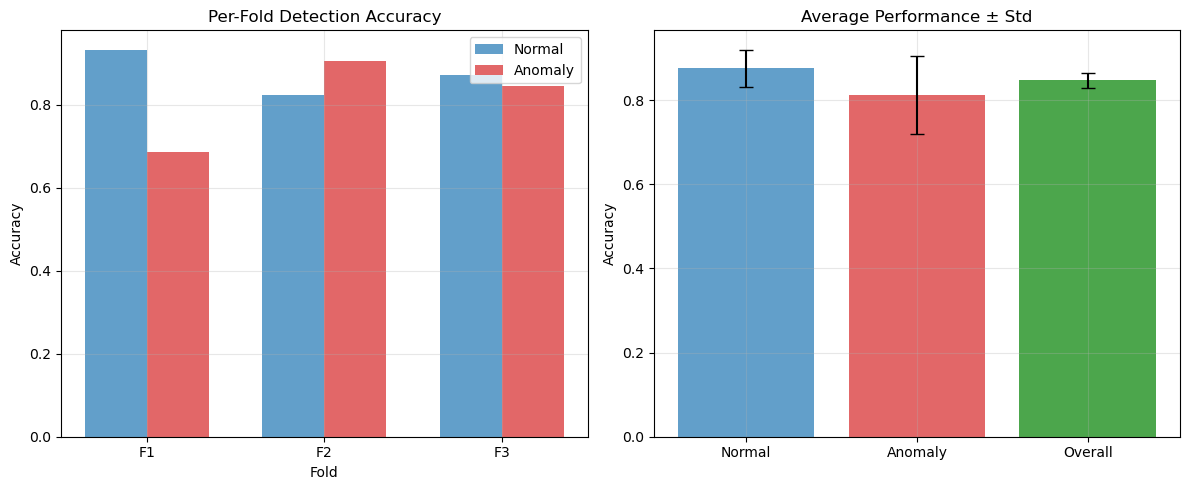


🎯 Distance-Based Summary:
   • Successfully evaluated 3/3 folds
   • Average anomaly detection: 0.812 ± 0.093
   • Average normal accuracy: 0.876 ± 0.044


In [6]:
# Distance-Based Results Summary and Visualization
if distance_evaluation_complete and distance_fold_results:
    print("📊 Distance-Based Per-Fold Performance Summary")
    print("=" * 45)

    # Calculate aggregate statistics
    valid_results = [r for r in distance_fold_results.values() if r is not None]

    if valid_results:
        avg_normal_acc = np.mean([r["normal_accuracy"] for r in valid_results])
        avg_anomaly_acc = np.mean([r["anomaly_accuracy"] for r in valid_results])
        avg_overall_acc = np.mean([r["overall_accuracy"] for r in valid_results])

        std_normal_acc = np.std([r["normal_accuracy"] for r in valid_results])
        std_anomaly_acc = np.std([r["anomaly_accuracy"] for r in valid_results])
        std_overall_acc = np.std([r["overall_accuracy"] for r in valid_results])

        print(f"\n{'Fold':<10} {'Normal':<8} {'Anomaly':<8} {'Overall':<8}")
        print("-" * 40)

        for fold_name, result in distance_fold_results.items():
            if result:
                print(
                    f"{fold_name:<10} {result['normal_accuracy']:<8.3f} {result['anomaly_accuracy']:<8.3f} {result['overall_accuracy']:<8.3f}"
                )

        print("-" * 40)
        print(
            f"{'Mean':<10} {avg_normal_acc:<8.3f} {avg_anomaly_acc:<8.3f} {avg_overall_acc:<8.3f}"
        )
        print(
            f"{'Std':<10} {std_normal_acc:<8.3f} {std_anomaly_acc:<8.3f} {std_overall_acc:<8.3f}"
        )

        # Import visualization class
        from src.visualization import AnomalyDetectionVisualizer

        distance_visualizer = AnomalyDetectionVisualizer()

        # Plot per-fold performance for distance method
        distance_visualizer.plot_per_fold_performance(distance_fold_results)

        print(f"\n🎯 Distance-Based Summary:")
        print(
            f"   • Successfully evaluated {len(valid_results)}/{len(distance_fold_results)} folds"
        )
        print(
            f"   • Average anomaly detection: {avg_anomaly_acc:.3f} ± {std_anomaly_acc:.3f}"
        )
        print(
            f"   • Average normal accuracy: {avg_normal_acc:.3f} ± {std_normal_acc:.3f}"
        )

    else:
        print("No valid results to display")

else:
    print("Distance-based evaluation not completed")

🏆 Best Performing Fold (Distance-Based): fold_2
   • Overall accuracy: 0.860
   • Normal accuracy: 0.824
   • Anomaly accuracy: 0.905
🏆 Best Performing Fold (Distance-Based): fold_2
   • ROC was inverted (AUC < 0.5), corrected: 0.064 → 0.936
   • Sample normal scores: [-0.62981489 -1.07804486  0.62358838 -0.33407673 -0.03889953]
   • Sample anomaly scores: [ 0.58228486  0.13248674  1.07927247 -0.03864347  0.98413367]
   • Converted normal anomaly scores: [ 0.62981489  1.07804486 -0.62358838  0.33407673  0.03889953]
   • Converted anomaly anomaly scores: [-0.58228486 -0.13248674 -1.07927247  0.03864347 -0.98413367]


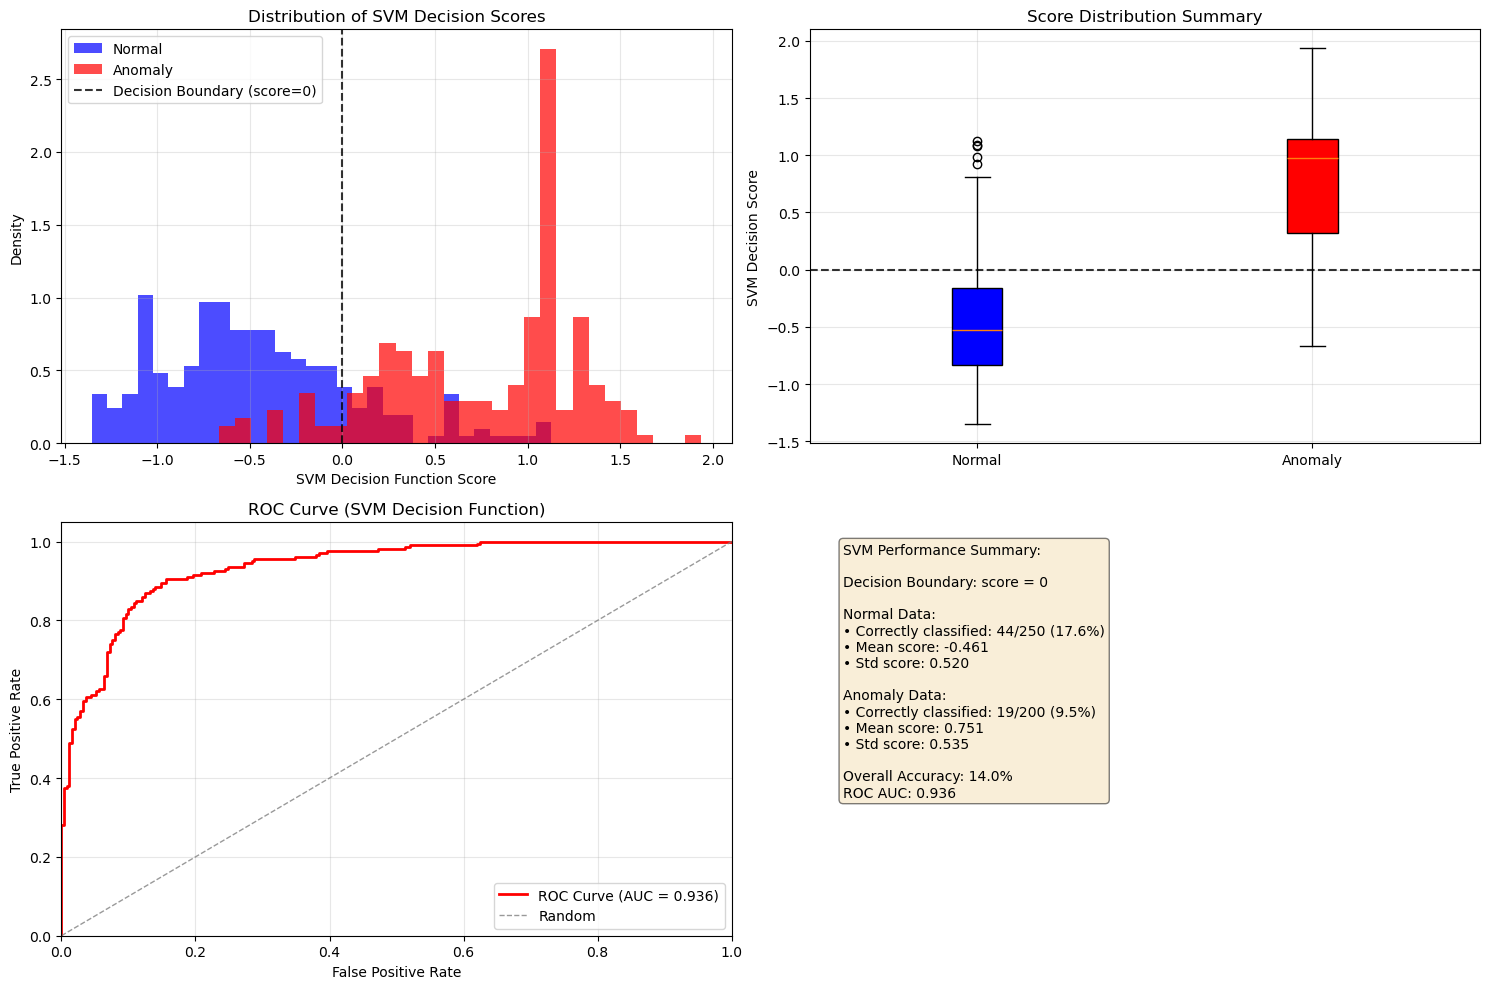


✅ SVM analysis visualization complete!
   • Overall accuracy: 0.140
   • Normal accuracy: 0.176
   • Anomaly accuracy: 0.095
   • ROC AUC: 0.936


In [7]:
# Detailed Distance-Based Analysis
if distance_evaluation_complete and distance_fold_results:
    # Find best performing fold for detailed analysis
    valid_folds = {k: v for k, v in distance_fold_results.items() if v is not None}

    if valid_folds:
        best_fold = max(valid_folds.items(), key=lambda x: x[1]["overall_accuracy"])
        best_fold_name, best_result = best_fold

        print(f"🏆 Best Performing Fold (Distance-Based): {best_fold_name}")
        print(f"   • Overall accuracy: {best_result['overall_accuracy']:.3f}")
        print(f"   • Normal accuracy: {best_result['normal_accuracy']:.3f}")
        print(f"   • Anomaly accuracy: {best_result['anomaly_accuracy']:.3f}")

        # Get the best fold's results for detailed analysis
        normal_scores_best = best_result["normal_scores"]
        anomaly_scores_best = best_result["anomaly_scores"]
        anomaly_classes_best = best_result["anomaly_classes"]

        # Use the enhanced visualization method from the module
        from src.visualization import AnomalyDetectionVisualizer

        distance_visualizer = AnomalyDetectionVisualizer()

        # Create comprehensive SVM analysis visualization
        svm_results = distance_visualizer.plot_svm_analysis(
            normal_scores_best,
            anomaly_scores_best,
            anomaly_classes_best,
            fold_name=best_fold_name,
        )

        print(f"\n✅ SVM analysis visualization complete!")
        print(f"   • Overall accuracy: {svm_results['overall_accuracy']:.3f}")
        print(f"   • Normal accuracy: {svm_results['normal_accuracy']:.3f}")
        print(f"   • Anomaly accuracy: {svm_results['anomaly_accuracy']:.3f}")
        print(f"   • ROC AUC: {svm_results['roc_auc']:.3f}")

else:
    print("No results available for detailed distance-based analysis")

## Autoencoder Architecture

An autoencoder is a neural network designed to learn efficient data representations through reconstruction. It consists of:

### Components:
1. **Encoder**: Compresses input data into a lower-dimensional latent representation
2. **Decoder**: Reconstructs the original input from the latent representation
3. **Latent Space**: The compressed representation capturing essential patterns

```
Input → [Encoder] → Latent Space → [Decoder] → Reconstructed Output
```

## Reconstruction Error Principle

The reconstruction error measures the difference between original input and autoencoder output. This error serves as an anomaly indicator.

### Mathematical Foundation:

**Reconstruction Error Formula:**
```
Error = ||x - x̂||²
```
Where:
- `x` = Original input
- `x̂` = Reconstructed output
- `||·||²` = Squared Euclidean norm (L2 norm)

### Anomaly Detection Mechanism:

1. **Normal Pattern Learning**: During training on normal data, the autoencoder learns to efficiently encode and decode typical patterns
2. **Compression Efficiency**: Normal patterns are represented in the latent space with low reconstruction error
3. **Anomaly Detection**: Anomalous patterns cannot be efficiently compressed using learned normal representations
4. **Error Threshold**: Higher reconstruction errors indicate deviations from learned normal patterns

## Detection Process

### 1. Training Phase (Normal Data Only):
```python
# Train autoencoder on normal patterns
for normal_sample in normal_data:
    latent = encoder(normal_sample)
    reconstructed = decoder(latent)
    loss = mse(normal_sample, reconstructed)
    # Minimize reconstruction error for normal patterns
```

### 2. Threshold Determination:
Calculate reconstruction errors on normal validation data and set threshold using:
- **Statistical method**: `threshold = μ + k×σ` (typically k=2 or 3)
- **Percentile-based**: 95th or 99th percentile of normal errors
- **ROC optimization**: Threshold that maximizes true positive rate

### 3. Detection Phase:
```python
# Detect anomalies in new data
reconstruction_error = ||x_new - autoencoder(x_new)||²
is_anomaly = reconstruction_error > threshold
```

## Statistical Foundation

### Normal Data Distribution:
- Reconstruction errors follow normal distribution for typical data
- Low mean error with small variance
- Predictable error patterns

### Anomaly Characteristics:
- Higher reconstruction errors due to poor fit with learned patterns
- Outlier behavior in error distribution
- Pattern deviation from training distribution

### Performance Metrics:
1. **True Positive Rate (Sensitivity)**: Correctly detected anomalies
2. **False Positive Rate**: Normal data incorrectly flagged as anomalous
3. **AUC-ROC**: Area under receiver operating characteristic curve
4. **Precision/Recall**: Trade-off between detection accuracy and false alarms

### Implementation Considerations:

1. **Unsupervised Learning**: Requires only normal operation data
2. **Real-time Detection**: Fast inference for continuous monitoring
3. **Adaptive Thresholds**: Can adjust to changing operational conditions
4. **Multivariate Analysis**: Considers relationships between multiple sensors
5. **Temporal Patterns**: LSTM autoencoders capture time-series dependencies

## 📊 Per-Fold Evaluation Strategy

### Proper Cross-Validation for Unsupervised Learning

**Per-Fold Training**: Train autoencoder on each fold's normal training data only
**Per-Fold Testing**: Evaluate on each fold's normal + anomaly test data

### Benefits of Per-Fold Evaluation:
- More robust performance estimates
- Prevents data leakage between folds
- Shows consistency across different data splits
- Better represents real-world deployment scenarios

In [8]:
# Import Required Libraries for Autoencoder
print("LSTM Autoencoder for Anomaly Detection")
print("=" * 45)

# Import required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Import custom modules
from src.autoencoder_models import StableLSTMAutoencoder
from src.unsupervised_preprocessing import UnsupervisedDataPreprocessor
from src.anomaly_detection import AnomalyDetector
from src.visualization import AnomalyDetectionVisualizer

# Set TensorFlow configuration
tf.config.run_functions_eagerly(False)

# Validate data availability
if data_ready and fold_data:
    print("✅ Data available for processing")
    print(f"   • Folds available: {len(fold_data)}")
    total_samples = sum(
        len(data["train_normal"]) + len(data["test_normal"]) + len(data["test_anomaly"])
        for data in fold_data.values()
    )
    print(f"   • Total samples across all folds: {total_samples}")
else:
    print("❌ No data available. Please run the previous cells first.")
    data_ready = False

LSTM Autoencoder for Anomaly Detection
✅ Data available for processing
   • Folds available: 3
   • Total samples across all folds: 2850


## 🧠 LSTM Autoencoder Architecture

### Why LSTM Autoencoders for Time Series?

**LSTM (Long Short-Term Memory)** networks are perfect for time series data because they:
- Remember long-term dependencies in sensor readings
- Capture temporal patterns in oil well operations
- Handle variable-length sequences effectively

### Autoencoder Components:
1. **LSTM Encoder**: Compresses time series into fixed-size latent vector
2. **Latent Space**: Compact representation of input patterns
3. **LSTM Decoder**: Reconstructs original time series from latent vector

### The Learning Process:
```
Normal Data → [LSTM Encoder] → Latent Vector → [LSTM Decoder] → Reconstructed Data
                                      ↓
                               Minimize reconstruction error
```

During training, the model learns to efficiently represent normal operation patterns.

This implementation uses a modular approach with reusable components in the `src/` directory:

### Modules:

1. **`autoencoder_models.py`** - Contains the `StableLSTMAutoencoder` class with:
   - Stable architecture with gradient clipping
   - Conservative hyperparameters for numerical stability
   - Built-in training and prediction methods

2. **`unsupervised_preprocessing.py`** - Contains the `UnsupervisedDataPreprocessor` class with:
   - Data sampling for training efficiency
   - Data validation and conversion
   - Numerical stability enhancements

3. **`anomaly_detection.py`** - Contains the `AnomalyDetector` class with:
   - Reconstruction error computation
   - Threshold determination methods
   - Performance evaluation and visualization

## 🏗️ Building and Training the Autoencoder

### Model Architecture Parameters

**Latent Dimension**: The "bottleneck" size that forces compression
- Smaller = more compression, may lose important details
- Larger = retains more information, less compression

**LSTM Units**: The "memory capacity" of each LSTM layer
- More units = can learn more complex patterns
- Fewer units = simpler model, faster training

### Training Strategy for Anomaly Detection

**Key Principle**: Train ONLY on normal data
- Model learns to reconstruct typical operational patterns
- Anomalies will have higher reconstruction errors because they weren't seen during training

**No Validation Split**: We use ALL normal data for training
- Maximizes the model's exposure to normal patterns
- Validation would be performed separately on mixed normal/anomaly data

In [9]:
# Per-Fold Training and Evaluation
if data_ready and fold_data:
    print("Per-Fold Autoencoder Training and Evaluation")
    print("=" * 45)

    # Store results for each fold
    fold_results = {}

    for fold_name, data in fold_data.items():
        print(f"\n🔄 Processing {fold_name}...")

        # Get fold data
        train_normal = data["train_normal"]
        test_normal = data["test_normal"]
        test_anomaly = data["test_anomaly"]
        test_anomaly_classes = data["test_anomaly_classes"]
        data_info = data["data_info"]

        # Build and train autoencoder for this fold
        autoencoder = StableLSTMAutoencoder(
            time_steps=data_info["time_steps"],
            n_features=data_info["n_features"],
            latent_dim=32,  # Smaller for efficiency
            lstm_units=64,  # Smaller for efficiency
        )

        model = autoencoder.build_model()

        # Train on fold's normal data only
        training_success = autoencoder.train(
            train_data=train_normal,
            val_data=None,
            epochs=20,  # Fewer epochs for efficiency
            batch_size=32,
            verbose=0,  # Less verbose
        )

        if training_success:
            # Evaluate on this fold's test data
            detector = AnomalyDetector()

            # Compute errors
            normal_errors, anomaly_errors = detector.compute_reconstruction_errors(
                autoencoder=autoencoder,
                normal_data=test_normal,
                anomaly_data=test_anomaly,
            )

            # Determine threshold
            threshold = detector.determine_threshold(method="percentile", percentile=95)

            # Calculate metrics
            metrics = detector.evaluate_detection()

            # Store results
            fold_results[fold_name] = {
                "normal_accuracy": metrics.get("normal_accuracy", 0),
                "anomaly_accuracy": metrics.get("anomaly_accuracy", 0),
                "overall_accuracy": metrics.get("overall_accuracy", 0),
                "threshold": threshold,
                "n_train": len(train_normal),
                "n_test_normal": len(test_normal),
                "n_test_anomaly": len(test_anomaly),
            }

            print(
                f"   ✅ Normal: {metrics.get('normal_accuracy', 0):.3f}, Anomaly: {metrics.get('anomaly_accuracy', 0):.3f}"
            )
        else:
            print(f"   ❌ Training failed")
            fold_results[fold_name] = None

    evaluation_complete = True

else:
    print("Cannot proceed - no fold data available")
    evaluation_complete = False

Per-Fold Autoencoder Training and Evaluation

🔄 Processing fold_1...
🏗️ Building Stable LSTM Autoencoder:
   • Input shape: (300, 3)
   • Encoder LSTM units: 64
   • Latent dimension: 32
   • Decoder LSTM units: 64

✅ Stable LSTM Autoencoder model created
   • Total parameters: 44,515
   • Gradient clipping enabled (clipnorm=1.0)
   • Conservative learning rate (0.0005)
🚂 Training LSTM Autoencoder:
   • Training samples: 500
   • No validation data - using all data for training
   • Max epochs: 20
   • Batch size: 32
✅ Training successful - no NaN values
   • Final training loss: 0.031439
📊 Computing Reconstruction Errors
🔵 Computing reconstruction errors for normal data...
🔴 Computing reconstruction errors for anomaly data...
✅ Reconstruction errors computed:
   • Normal errors: 250 samples
   • Anomaly errors: 200 samples
   • Normal error range: [0.000933, 0.119453]
   • Anomaly error range: [0.013348, 0.381964]
🎯 Determining Anomaly Threshold (percentile)
📈 Threshold set at 95th pe

📊 Per-Fold Performance Summary

Fold       Normal   Anomaly  Overall 
----------------------------------------
fold_1     0.948    0.715    0.844   
fold_2     0.948    0.870    0.913   
fold_3     0.948    0.665    0.822   
----------------------------------------
Mean       0.948    0.750    0.860   
Std        0.000    0.087    0.039   


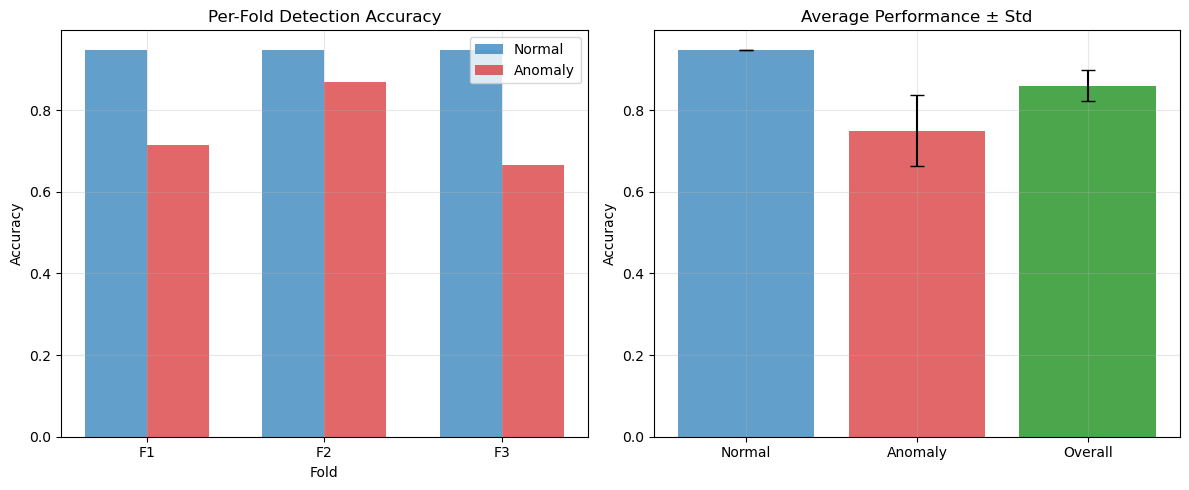


🎯 Summary:
   • Successfully evaluated 3/3 folds
   • Average anomaly detection: 0.750 ± 0.087
   • Average normal accuracy: 0.948 ± 0.000


In [10]:
# Per-Fold Results Summary
if evaluation_complete and fold_results:
    print("📊 Per-Fold Performance Summary")
    print("=" * 35)

    # Calculate aggregate statistics
    valid_results = [r for r in fold_results.values() if r is not None]

    if valid_results:
        avg_normal_acc = np.mean([r["normal_accuracy"] for r in valid_results])
        avg_anomaly_acc = np.mean([r["anomaly_accuracy"] for r in valid_results])
        avg_overall_acc = np.mean([r["overall_accuracy"] for r in valid_results])

        std_normal_acc = np.std([r["normal_accuracy"] for r in valid_results])
        std_anomaly_acc = np.std([r["anomaly_accuracy"] for r in valid_results])
        std_overall_acc = np.std([r["overall_accuracy"] for r in valid_results])

        print(f"\n{'Fold':<10} {'Normal':<8} {'Anomaly':<8} {'Overall':<8}")
        print("-" * 40)

        for fold_name, result in fold_results.items():
            if result:
                print(
                    f"{fold_name:<10} {result['normal_accuracy']:<8.3f} {result['anomaly_accuracy']:<8.3f} {result['overall_accuracy']:<8.3f}"
                )

        print("-" * 40)
        print(
            f"{'Mean':<10} {avg_normal_acc:<8.3f} {avg_anomaly_acc:<8.3f} {avg_overall_acc:<8.3f}"
        )
        print(
            f"{'Std':<10} {std_normal_acc:<8.3f} {std_anomaly_acc:<8.3f} {std_overall_acc:<8.3f}"
        )

        # Use the new visualization class
        from src.visualization import AnomalyDetectionVisualizer

        visualizer = AnomalyDetectionVisualizer()

        # Plot per-fold performance
        visualizer.plot_per_fold_performance(fold_results)

        print(f"\n🎯 Summary:")
        print(
            f"   • Successfully evaluated {len(valid_results)}/{len(fold_results)} folds"
        )
        print(
            f"   • Average anomaly detection: {avg_anomaly_acc:.3f} ± {std_anomaly_acc:.3f}"
        )
        print(
            f"   • Average normal accuracy: {avg_normal_acc:.3f} ± {std_normal_acc:.3f}"
        )

    else:
        print("No valid results to display")

else:
    print("Per-fold evaluation not completed")

🏆 Best Performing Fold: fold_2
   • Overall accuracy: 0.913
   • Normal accuracy: 0.948
   • Anomaly accuracy: 0.870

Re-training autoencoder on fold_2 for detailed analysis...
🏗️ Building Stable LSTM Autoencoder:
   • Input shape: (300, 3)
   • Encoder LSTM units: 64
   • Latent dimension: 32
   • Decoder LSTM units: 64
✅ Stable LSTM Autoencoder model created
   • Total parameters: 44,515
   • Gradient clipping enabled (clipnorm=1.0)
   • Conservative learning rate (0.0005)
🚂 Training LSTM Autoencoder:
   • Training samples: 500
   • No validation data - using all data for training
   • Max epochs: 20
   • Batch size: 32
✅ Training successful - no NaN values
   • Final training loss: 0.029179
📊 Computing Reconstruction Errors
🔵 Computing reconstruction errors for normal data...
🔴 Computing reconstruction errors for anomaly data...
✅ Reconstruction errors computed:
   • Normal errors: 250 samples
   • Anomaly errors: 200 samples
   • Normal error range: [0.001531, 0.119837]
   • Anomal

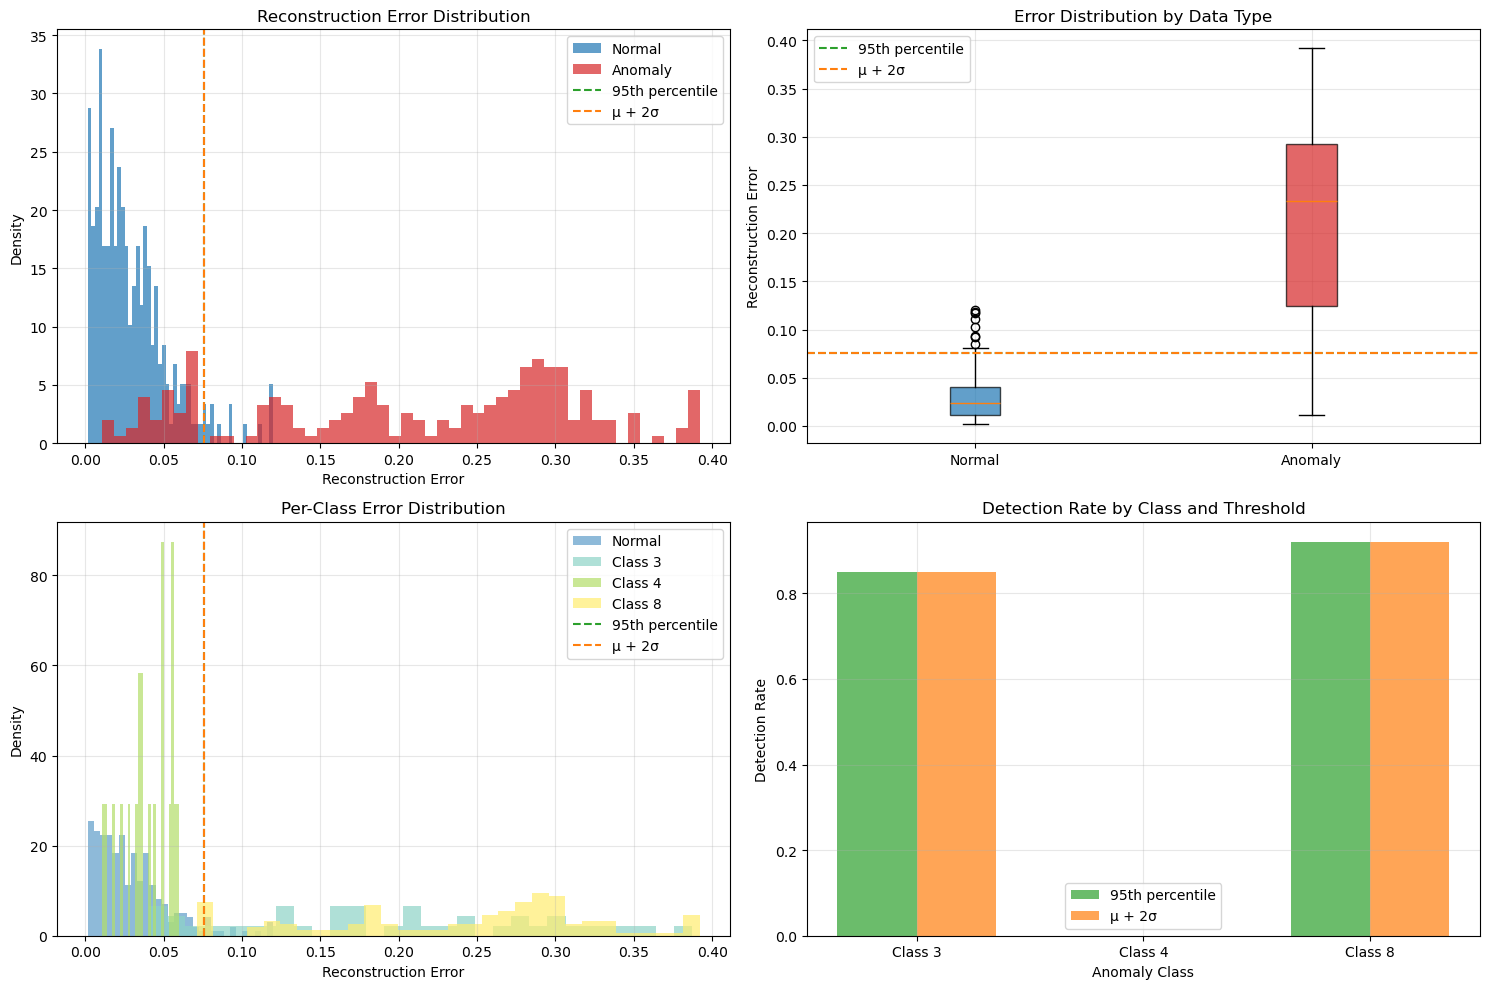

Threshold Analysis:
  • 95th percentile: 0.075499
  • μ + 2σ: 0.075691

🗺️ Latent Space Analysis for fold_2
Computing t-SNE embedding for 450 samples...


c:\Users\lucas\.conda\envs\3W-ml-mts\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


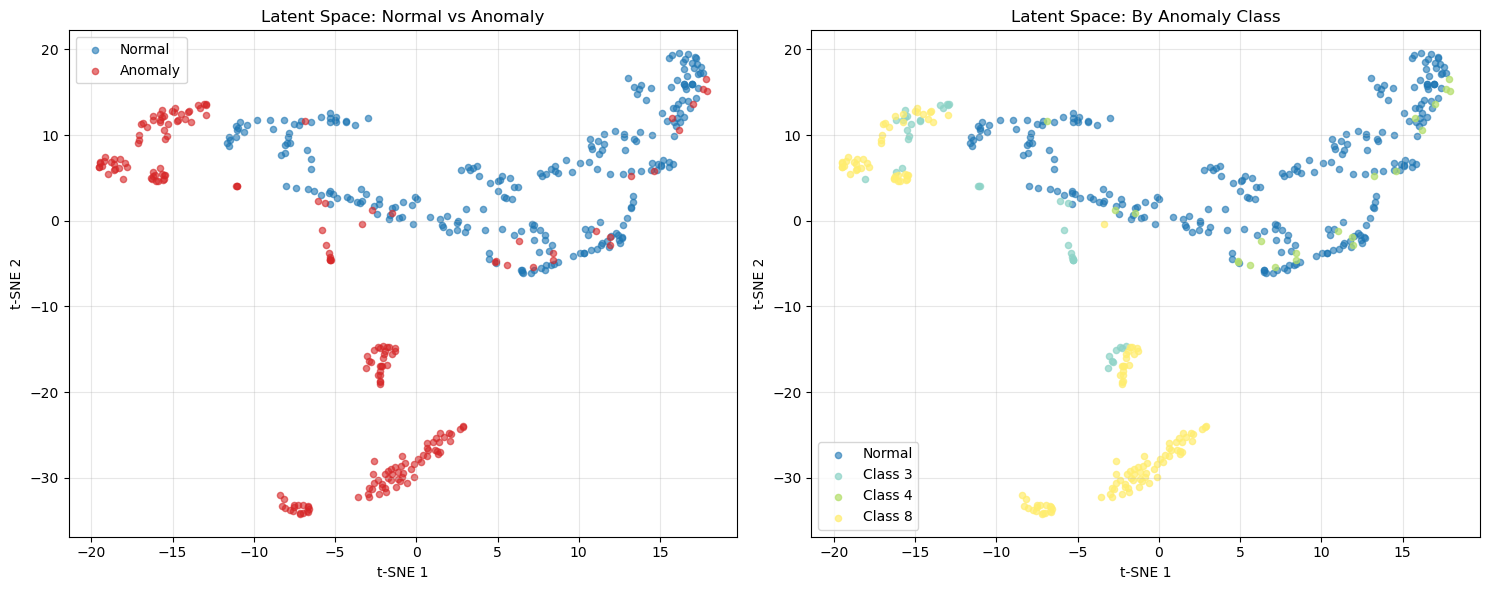

In [11]:
# Detailed Analysis: Reconstruction Errors and Latent Space
if evaluation_complete and fold_results:
    # Find best performing fold for detailed analysis
    valid_folds = {k: v for k, v in fold_results.items() if v is not None}

    if valid_folds:
        best_fold = max(valid_folds.items(), key=lambda x: x[1]["overall_accuracy"])
        best_fold_name, best_result = best_fold

        print(f"🏆 Best Performing Fold: {best_fold_name}")
        print(f"   • Overall accuracy: {best_result['overall_accuracy']:.3f}")
        print(f"   • Normal accuracy: {best_result['normal_accuracy']:.3f}")
        print(f"   • Anomaly accuracy: {best_result['anomaly_accuracy']:.3f}")

        # Get the best fold's data for detailed analysis
        best_fold_data = fold_data[best_fold_name]
        test_normal_best = best_fold_data["test_normal"]
        test_anomaly_best = best_fold_data["test_anomaly"]
        test_anomaly_classes_best = best_fold_data["test_anomaly_classes"]

        # Re-train autoencoder on best fold for visualization
        print(f"\nRe-training autoencoder on {best_fold_name} for detailed analysis...")

        # Build autoencoder
        autoencoder_best = StableLSTMAutoencoder(
            time_steps=best_fold_data["data_info"]["time_steps"],
            n_features=best_fold_data["data_info"]["n_features"],
            latent_dim=32,
            lstm_units=64,
        )
        model_best = autoencoder_best.build_model()

        # Train
        training_success = autoencoder_best.train(
            train_data=best_fold_data["train_normal"],
            val_data=None,
            epochs=20,
            batch_size=32,
            verbose=0,
        )

        if training_success:
            # Compute reconstruction errors
            detector_best = AnomalyDetector()
            normal_errors_best, anomaly_errors_best = (
                detector_best.compute_reconstruction_errors(
                    autoencoder=autoencoder_best,
                    normal_data=test_normal_best,
                    anomaly_data=test_anomaly_best,
                )
            )

            # Visualize reconstruction errors with thresholds
            print(f"\n📊 Reconstruction Error Analysis for {best_fold_name}")
            visualizer.plot_reconstruction_errors(
                normal_errors_best,
                anomaly_errors_best,
                test_anomaly_classes_best,
                threshold_percentile=95,
                threshold_std_multiplier=2,
            )

            # Visualize latent space with t-SNE
            print(f"\n🗺️ Latent Space Analysis for {best_fold_name}")
            visualizer.plot_latent_space_tsne(
                autoencoder_best,
                test_normal_best,
                test_anomaly_best,
                test_anomaly_classes_best,
                max_samples=800,
                perplexity=30,
            )
        else:
            print("Failed to train autoencoder for detailed analysis")

else:
    print("No results available for detailed analysis")


📈 ROC Curve Analysis for fold_2


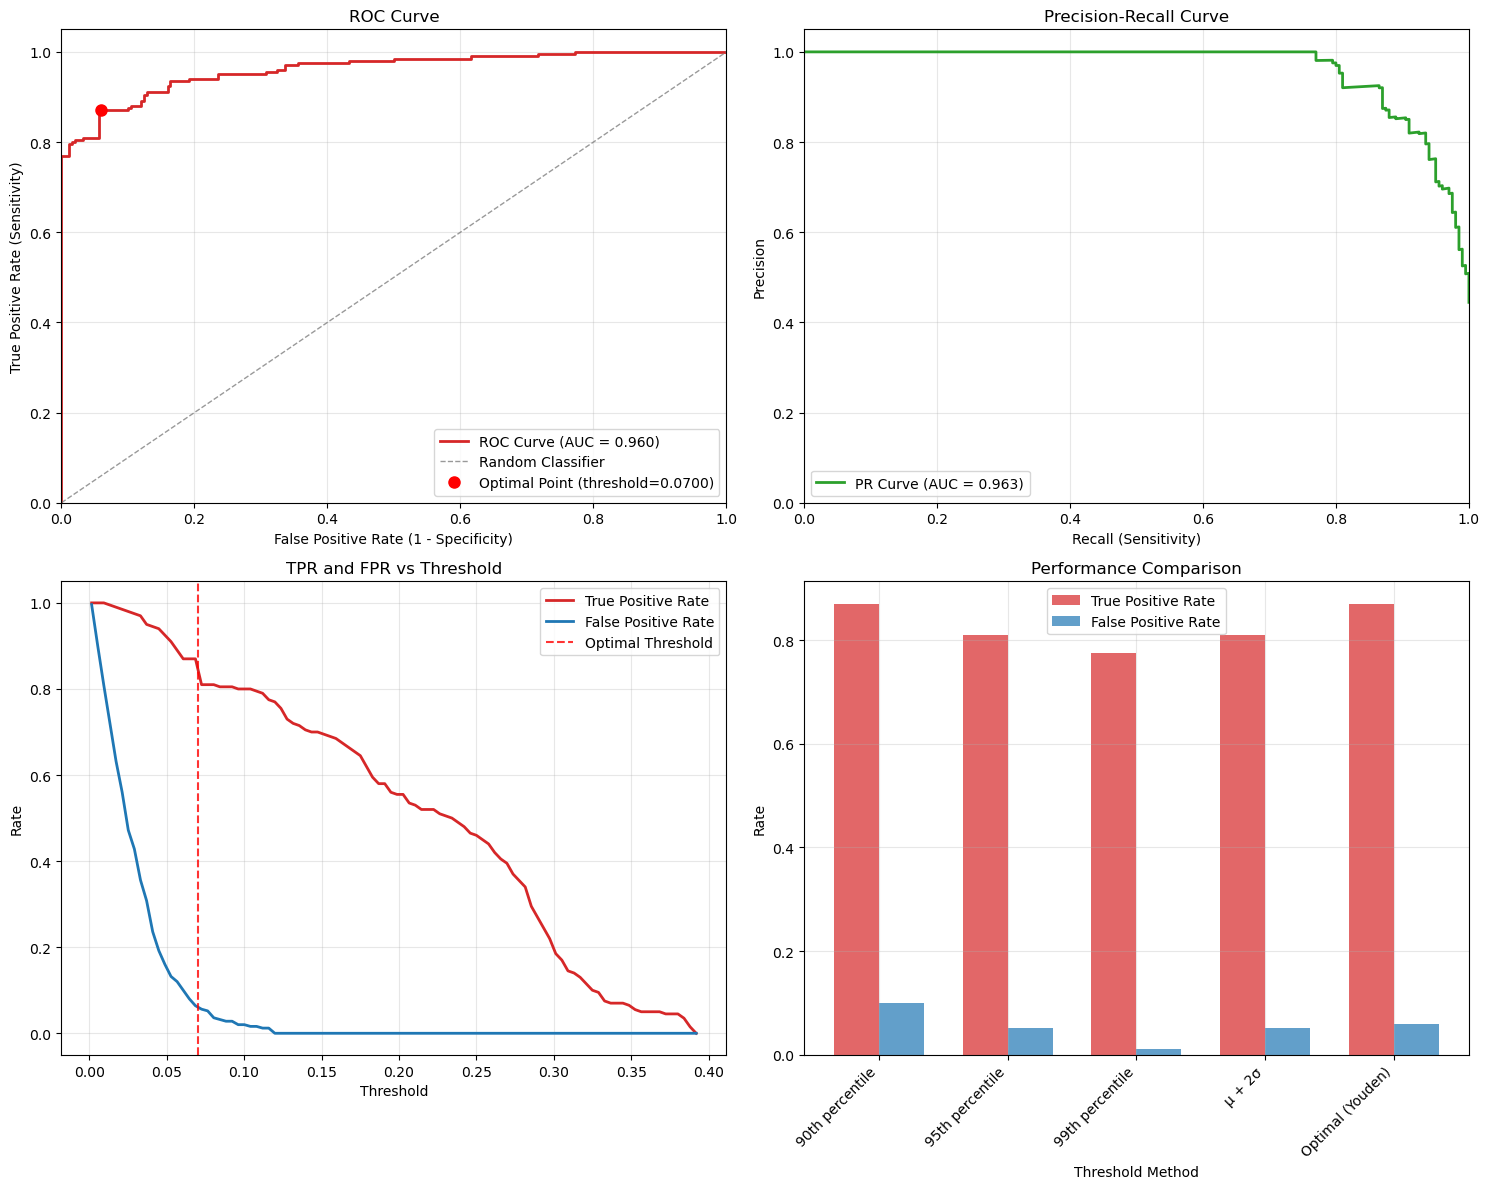


📊 ROC Analysis Results:
   • ROC AUC: 0.960
   • PR AUC: 0.963
   • Optimal threshold (Youden's): 0.069971
   • At optimal threshold - TPR: 0.870, FPR: 0.060

📋 Threshold Method Comparison:
Method          Threshold    TPR      FPR      Precision
-------------------------------------------------------
90th percentile 0.060238     0.870    0.100    0.874   
95th percentile 0.075499     0.810    0.052    0.926   
99th percentile 0.114428     0.775    0.012    0.981   
μ + 2σ          0.075691     0.810    0.052    0.926   
Optimal (Youden) 0.069971     0.870    0.060    0.926   

🎯 Performance Interpretation:
   • Excellent discrimination (AUC ≥ 0.9)

✅ ROC analysis complete!


In [12]:
# ROC Curve Analysis
if (
    evaluation_complete
    and "normal_errors_best" in locals()
    and "anomaly_errors_best" in locals()
):
    print(f"\n📈 ROC Curve Analysis for {best_fold_name}")
    roc_results = visualizer.plot_roc_analysis(
        normal_errors_best, anomaly_errors_best, test_anomaly_classes_best
    )

    print(f"\n✅ ROC analysis complete!")
else:
    print("❌ ROC analysis requires valid reconstruction errors from previous cell")